In [1]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/red_pill_analises/'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import os

Mounted at /content/drive


Antes, na anonimização, o mapeamento estava sendo realizado de maneira independente para canais e comentários, o que dificultava o processo de procurar por autores comentadores. Assim, vou realizar um novo processo de anonimização (dessa vez, considerando as duas tabelas) e limpeza (exatamente igual à anterior)

In [2]:
caminho_brutos = folder_path + 'data_base/dados_brutos/'
caminho_anonimizados = folder_path + 'data_base/dados_anonimizados/'
caminho_limpos = folder_path + 'data_base/dados_limpos/'

In [3]:
# Garante que as pastas existem
os.makedirs(caminho_anonimizados, exist_ok=True)
os.makedirs(caminho_limpos, exist_ok=True)

# ==============================================================================
# 1. CARREGAMENTO E FILTRAGEM (Igual ao original)
# ==============================================================================
print("--- 1. Carregando e Filtrando Dados Brutos ---")

df_channels = pd.read_csv(caminho_brutos + 'canais_brutos.csv')
df_videos = pd.read_csv(caminho_brutos + 'videos_brutos.csv')
df_comments = pd.read_csv(caminho_brutos + 'comentarios_brutos.csv')

# Filtro de canais válidos
channels_validos = set(df_channels['channel_id'])
df_videos = df_videos[df_videos['channel_id'].isin(channels_validos)].copy()

# Filtro de data
df_videos['published_at'] = pd.to_datetime(df_videos['published_at'], utc=True)
df_videos = df_videos[df_videos['published_at'] >= pd.Timestamp('2024-01-01', tz='UTC')]

# Filtro de comentários válidos
videos_validos = set(df_videos['video_id'])
df_comments = df_comments[df_comments['video_id'].isin(videos_validos)].copy()

print(f"Dados filtrados: Canais: {df_channels.shape[0]}, Vídeos: {df_videos.shape[0]}, Comentários: {df_comments.shape[0]}")


caminho_para_salvar = folder_path + 'data_base/dados_anonimizados_e_limpos_para_analise_comentadores/'
os.makedirs(caminho_para_salvar, exist_ok=True)

# ==============================================================================
# 2. ANONIMIZAÇÃO INTELIGENTE (A Correção)
# ==============================================================================
print("--- 2. Iniciando Anonimização Unificada ---")

# --- Passo A: Criar Mapa dos Canais Principais (Donos dos vídeos) ---
# Ordenar canais por quantidade de vídeos (lógica original)
channel_counts = df_videos['channel_id'].value_counts().reset_index()
channel_counts.columns = ['channel_id', 'count']
channel_counts = channel_counts.sort_values(by='count', ascending=False)

# Dicionário Mestre: channel_id_original -> id_anonimizado
mapa_identidades = {}

# Preencher com os canais principais
for i, row in enumerate(channel_counts.itertuples()):
    mapa_identidades[row.channel_id] = f'canal_{i+1}'

# --- Passo B: Criar Mapa dos Autores de Comentários ---
# Pegar todos os autores únicos dos comentários
autores_comentarios = df_comments['author_channel_id'].dropna().unique()

# Contador para autores que NÃO são donos de canais monitorados
contador_autores_externos = 1

for autor_id in autores_comentarios:
    # Se o autor já está no mapa (ou seja, é um dos canais principais), não fazemos nada.
    # Ele já vai receber o ID 'canal_X'
    if autor_id not in mapa_identidades:
        # Se não está, é um usuário comum
        mapa_identidades[autor_id] = f'autor_{contador_autores_externos}'
        contador_autores_externos += 1

# --- Passo C: Aplicar os Mapas ---

# 1. Nos Canais
df_channels['id_canal_anonimizado'] = df_channels['channel_id'].map(mapa_identidades)

# 2. Nos Vídeos (Dono do vídeo)
df_videos['id_canal_anonimizado'] = df_videos['channel_id'].map(mapa_identidades)

# 3. Nos Comentários (Autor do comentário)
# .fillna('[autor_desconhecido]') trata casos onde author_channel_id é nulo
df_comments['id_autor_anonimizado'] = df_comments['author_channel_id'].map(mapa_identidades).fillna('[autor_desconhecido]')

# 4. Adicionar id_canal_anonimizado (Dono do vídeo onde foi feito o comentário) ao df_comments
# Primeiro mapeamos o video_id para o channel_id do vídeo
video_to_channel_map = df_videos.set_index('video_id')['id_canal_anonimizado'].to_dict()
df_comments['id_canal_anonimizado'] = df_comments['video_id'].map(video_to_channel_map)


# --- Passo D: Anonimizar Vídeos (Sequencial por Views) ---
df_videos = df_videos.sort_values(by='view_count', ascending=False).reset_index(drop=True)
df_videos['id_video_anonimizado'] = df_videos.index.map(lambda i: f"video_{i + 1}")

# Passar o id_video_anonimizado para os comentários
video_id_map = df_videos.set_index('video_id')['id_video_anonimizado'].to_dict()
df_comments['id_video_anonimizado'] = df_comments['video_id'].map(video_id_map)

# --- Passo E: Anonimizar IDs de Comentários ---
df_comments = df_comments.sort_values(by=['id_video_anonimizado', 'published_at']).reset_index(drop=True)
df_comments['id_comentario_anonimizado'] = df_comments.index.map(lambda i: f"comentario_{i + 1}")

# --- Passo F: Anonimizar Textos ---
def anonimizar_texto_avancado(texto):
    if not isinstance(texto, str):
        return ''
    texto_anon = re.sub(r'@\w+', '[MENCAO]', texto)
    texto_anon = re.sub(r'\S+@\S+', '[EMAIL]', texto_anon)
    return texto_anon.strip()

df_channels['description'] = df_channels['description'].apply(anonimizar_texto_avancado)
df_videos['title'] = df_videos['title'].apply(anonimizar_texto_avancado)
df_videos['description'] = df_videos['description'].apply(anonimizar_texto_avancado)
df_comments['comment'] = df_comments['comment'].apply(anonimizar_texto_avancado)

# --- SALVAR DADOS ANONIMIZADOS ---
# (Mantendo colunas essenciais para a limpeza)
cols_channels = df_channels.columns.tolist() # Salva tudo por enquanto para limpeza
cols_videos = ['id_video_anonimizado', 'id_canal_anonimizado', 'title', 'description', 'published_at', 'view_count', 'like_count', 'comment_count']
cols_comments = ['id_comentario_anonimizado', 'id_video_anonimizado', 'id_canal_anonimizado', 'id_autor_anonimizado', 'comment', 'published_at', 'like_count']

df_channels_anon = df_channels.copy() # Salvamos cópia para não perder dados originais na memória
df_videos_anon = df_videos[cols_videos].copy()
df_comments_anon = df_comments[cols_comments].copy()

df_channels_anon.to_csv(caminho_para_salvar + 'canais_anonimizados.csv', index=False)
df_videos_anon.to_csv(caminho_para_salvar + 'videos_anonimizados.csv', index=False)
df_comments_anon.to_csv(caminho_para_salvar +'comentarios_anonimizados.csv', index=False)

print("Anonimização concluída. Donos de canais preservados nos comentários.")

# ==============================================================================
# 3. LIMPEZA DOS DADOS (Exatamente igual ao script anterior)
# ==============================================================================
print("--- 3. Iniciando Limpeza ---")

# Funções Auxiliares
def extract_emojis(text):
    emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF"
        "\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF"
        "\U00002702-\U000027B0\U00002600-\U000026FF\U0000FE0E-\U0000FE0F"
        "\U0001F1E0-\U0001F1FF\U0000200D"
        "]+", flags=re.UNICODE)
    emojis = emoji_pattern.findall(text)
    return "".join(emojis)

def extract_hashtags(text):
    hashtag_pattern = re.compile(r"#\w+")
    hashtags = hashtag_pattern.findall(text)
    return " ".join(hashtags)

# --- A. Limpeza Canais ---
# Usamos df_channels_anon que acabamos de criar
df_channels_anon['text'] = df_channels_anon['description'].fillna('')
df_channels_anon['text'] = df_channels_anon['text'].str.replace(r'[\n\t]', '', regex=True)
df_channels_anon['text'] = (
    df_channels_anon['text']
    .str.replace(r'\[MENCAO\]', ' ', regex=True)
    .str.replace(r'\[EMAIL\]', ' ', regex=True)
)

# Drop colunas originais de texto (conforme seu script de limpeza)
# Nota: Seu script original dropava 'title' mas a anonimização dos canais removeu title antes.
# Ajustei para remover 'description' e manter apenas colunas anonimizadas + text
df_channels_limpo = df_channels_anon.drop(columns=['description', 'channel_id', 'title'], errors='ignore').copy()

df_channels_limpo['emojis'] = df_channels_limpo['text'].apply(extract_emojis)
df_channels_limpo['hashtags'] = df_channels_limpo['text'].apply(extract_hashtags)
df_channels_limpo.to_csv(caminho_para_salvar + 'canais_limpos.csv', index=False)


# --- B. Limpeza Vídeos ---
df_videos_anon['text'] = df_videos_anon['title'].fillna('') + ' ' + df_videos_anon['description'].fillna('')
df_videos_anon['text'] = df_videos_anon['text'].str.replace(r'[\n\t]', '', regex=True)
df_videos_anon['text'] = (
    df_videos_anon['text']
    .str.replace(r'\[MENCAO\]', ' ', regex=True)
    .str.replace(r'\[EMAIL\]', ' ', regex=True)
)

df_videos_limpo = df_videos_anon.drop(columns=['title', 'description'], axis=1).copy()
df_videos_limpo['emojis'] = df_videos_limpo['text'].apply(extract_emojis)
df_videos_limpo['hashtags'] = df_videos_limpo['text'].apply(extract_hashtags)
df_videos_limpo.to_csv(caminho_para_salvar + 'videos_limpos.csv', index=False)


# --- C. Limpeza Comentários ---
df_comments_anon['comment'] = df_comments_anon['comment'].str.replace(r'[\n\t]', '', regex=True)

df_comments_anon['comment'] = df_comments_anon['comment'].fillna('')
df_comments_anon['emojis'] = df_comments_anon['comment'].apply(extract_emojis)
df_comments_anon['hashtags'] = df_comments_anon['comment'].apply(extract_hashtags)

df_comments_anon['comment'] = (
    df_comments_anon['comment']
    .str.replace(r'\[MENCAO\]', ' ', regex=True)
    .str.replace(r'\[EMAIL\]', ' ', regex=True)
)

df_comments_limpo = df_comments_anon.rename(columns={'comment': 'text'})

MIN_CHAR_LENGTH = 30
df_comments_limpo = df_comments_limpo[df_comments_limpo['text'].astype(str).apply(lambda x: len(x.strip()) >= MIN_CHAR_LENGTH)]

df_comments_limpo.to_csv(caminho_para_salvar + 'comentarios_limpos.csv', index=False)

print("Limpeza concluída e arquivos salvos!")

--- 1. Carregando e Filtrando Dados Brutos ---
Dados filtrados: Canais: 28, Vídeos: 18034, Comentários: 3037221
--- 2. Iniciando Anonimização Unificada ---
Anonimização concluída. Donos de canais preservados nos comentários.
--- 3. Iniciando Limpeza ---
Limpeza concluída e arquivos salvos!


## Conferência comparativa com os dados anteriores

In [4]:
df_canais_og = pd.read_csv(caminho_limpos + 'canais_limpos.csv')
df_videos_og = pd.read_csv(caminho_limpos + 'videos_limpos.csv')
df_comments_og = pd.read_csv(caminho_limpos + 'comentarios_limpos.csv')

In [5]:
print(
    f"Dados limpos originais: Canais: {df_canais_og.shape[0]}, Vídeos: {df_videos_og.shape[0]}, Comentários: {df_comments_og.shape[0]}\n",
    f"Dados limpos novos: Canais: {df_channels_limpo.shape[0]}, Vídeos: {df_videos_limpo.shape[0]}, Comentários: {df_comments_limpo.shape[0]}"
)

Dados limpos originais: Canais: 28, Vídeos: 18034, Comentários: 2238836
 Dados limpos novos: Canais: 28, Vídeos: 18034, Comentários: 2238836


## Análises

In [6]:
# Cria uma coluna booleana facilitadora: True se o autor do comentário é o dono do canal
df_comments = df_comments_limpo.copy()
df_comments['is_owner'] = df_comments['id_autor_anonimizado'] == df_comments['id_canal_anonimizado']

/tmp/ipython-input-4280792363.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=videos_com_interacao, x='id_canal_anonimizado', y='num_videos_comentados', palette='viridis')


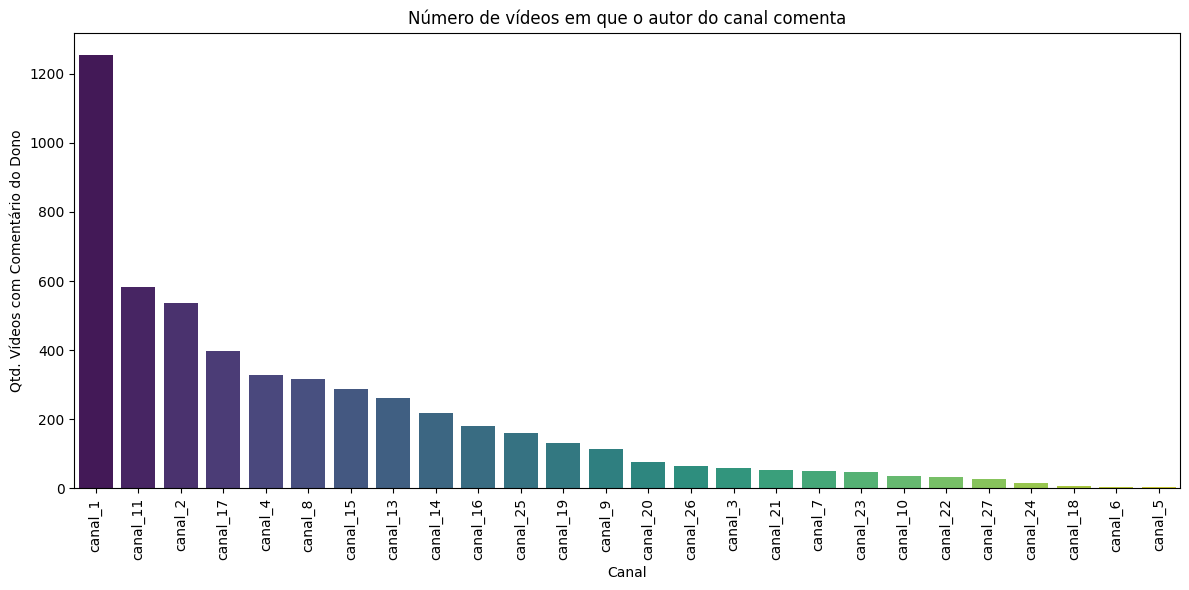

In [7]:
# Celula 1: Tarefa 1
plt.figure(figsize=(12, 6))

# Agrupa por canal e conta quantos vídeos únicos têm pelo menos um comentário do dono (is_owner=True)
videos_com_interacao = df_comments[df_comments['is_owner']].groupby('id_canal_anonimizado')['id_video_anonimizado'].nunique().reset_index()
videos_com_interacao.columns = ['id_canal_anonimizado', 'num_videos_comentados']

# Ordena para melhor visualização
videos_com_interacao = videos_com_interacao.sort_values(by='num_videos_comentados', ascending=False)

# Plot
sns.barplot(data=videos_com_interacao, x='id_canal_anonimizado', y='num_videos_comentados', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Canal')
plt.ylabel('Qtd. Vídeos com Comentário do Dono')
plt.title('Número de vídeos em que o autor do canal comenta')
plt.tight_layout()
plt.show()

/tmp/ipython-input-731501969.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_task2, x='id_canal_anonimizado', y='qtd_comentarios_dono', palette='viridis')


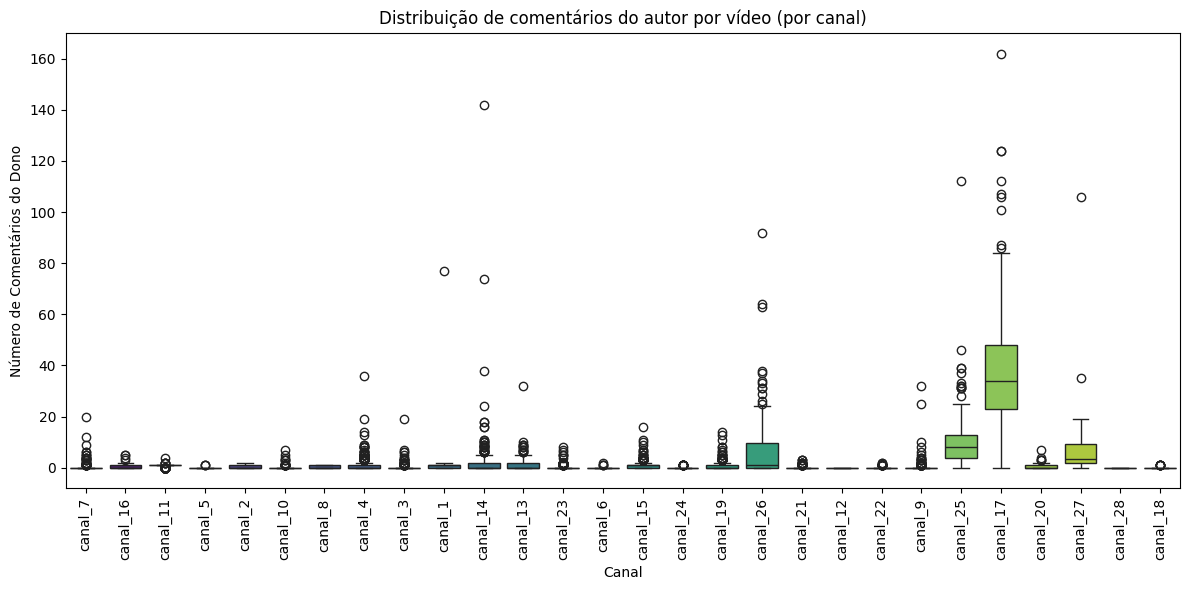

In [8]:
# Celula 2: Tarefa 2
plt.figure(figsize=(12, 6))

# 1. Conta quantos comentários do dono existem por vídeo
owner_comments_per_video = df_comments[df_comments['is_owner']].groupby('id_video_anonimizado').size().reset_index(name='qtd_comentarios_dono')

# 2. Garante que todos os vídeos apareçam, preenchendo com 0 os que não têm comentário do dono
# Pegamos a lista de todos os vídeos e seus respectivos canais
all_videos_map = df_videos[['id_video_anonimizado', 'id_canal_anonimizado']].drop_duplicates()

# Faz o merge
df_task2 = pd.merge(all_videos_map, owner_comments_per_video, on='id_video_anonimizado', how='left')
df_task2['qtd_comentarios_dono'] = df_task2['qtd_comentarios_dono'].fillna(0)

# Plot
sns.boxplot(data=df_task2, x='id_canal_anonimizado', y='qtd_comentarios_dono', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Canal')
plt.ylabel('Número de Comentários do Dono')
plt.title('Distribuição de comentários do autor por vídeo (por canal)')
plt.tight_layout()
plt.show()

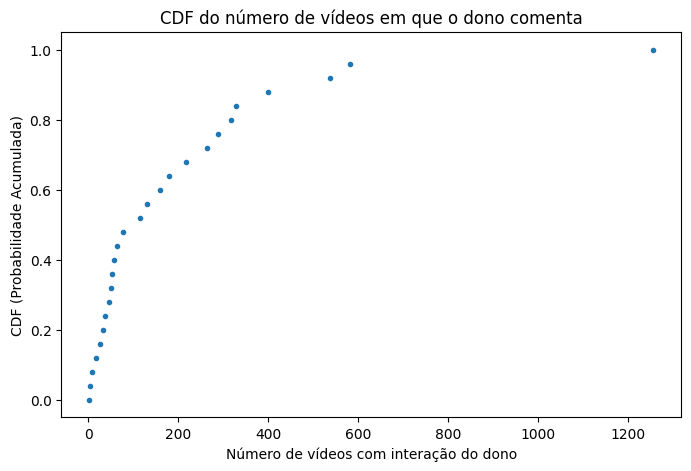

In [9]:
# Celula 3: Tarefa 3
# Dados calculados na Tarefa 1: Quantos vídeos cada dono comentou
data_cdf = videos_com_interacao['num_videos_comentados'].sort_values()

# Cálculo da CDF
yvals = np.arange(len(data_cdf)) / float(len(data_cdf) - 1)

plt.figure(figsize=(8, 5))
plt.plot(data_cdf, yvals, marker='.', linestyle='none')
plt.xlabel('Número de vídeos com interação do dono')
plt.ylabel('CDF (Probabilidade Acumulada)')
plt.title('CDF do número de vídeos em que o dono comenta')
plt.grid(False)
plt.show()

/tmp/ipython-input-4108224042.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_task4, x='id_canal_anonimizado', y='pct_owner', palette='viridis')


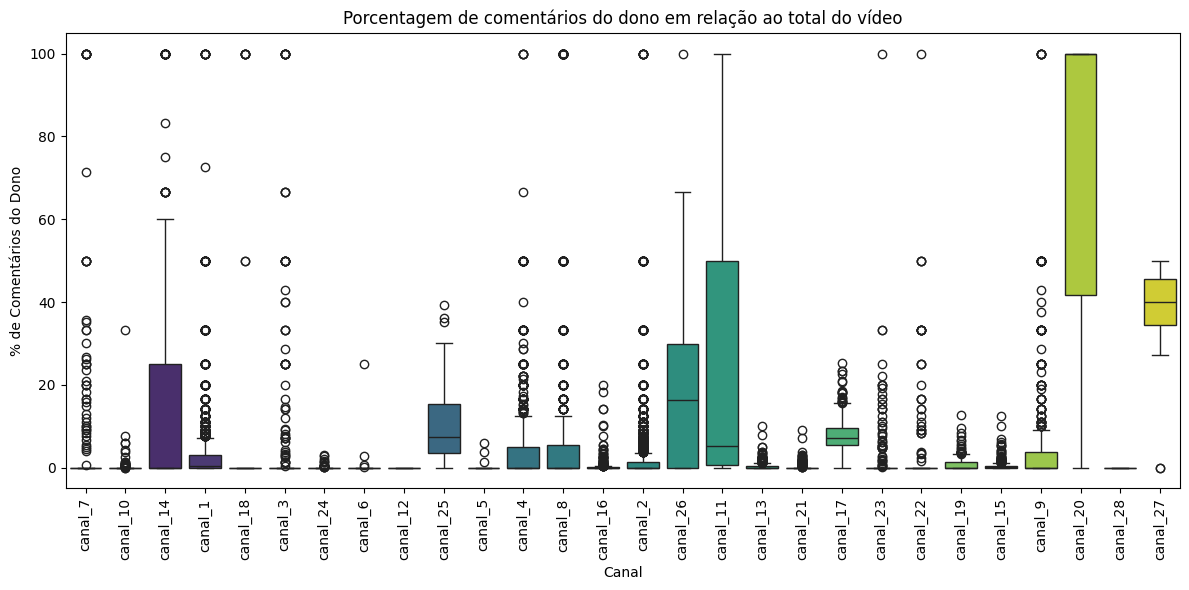

In [10]:
# Celula 4: Tarefa 4
plt.figure(figsize=(12, 6))

# 1. Total de comentários por vídeo
total_comments = df_comments.groupby('id_video_anonimizado').size().reset_index(name='total_comments')

# 2. Comentários do dono por vídeo
owner_comments = df_comments[df_comments['is_owner']].groupby('id_video_anonimizado').size().reset_index(name='owner_comments')

# 3. Junta tudo e calcula porcentagem
df_task4 = pd.merge(total_comments, owner_comments, on='id_video_anonimizado', how='left')
df_task4['owner_comments'] = df_task4['owner_comments'].fillna(0)
df_task4['pct_owner'] = (df_task4['owner_comments'] / df_task4['total_comments']) * 100

# 4. Adiciona a informação do canal para o plot
df_task4 = pd.merge(df_task4, df_videos[['id_video_anonimizado', 'id_canal_anonimizado']], on='id_video_anonimizado', how='left')

# Plot
sns.boxplot(data=df_task4, x='id_canal_anonimizado', y='pct_owner', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Canal')
plt.ylabel('% de Comentários do Dono')
plt.title('Porcentagem de comentários do dono em relação ao total do vídeo')
plt.tight_layout()
plt.show()

In [11]:
pd.options.display.max_colwidth = None

df_comments[
    df_comments['is_owner'] == 1
    ].head(10)[
        ['id_video_anonimizado',
         'id_canal_anonimizado',
         'id_autor_anonimizado',
         'text',
         'is_owner']]

,id_video_anonimizado,id_canal_anonimizado,id_autor_anonimizado,text,is_owner
4834,video_100,canal_14,canal_14,Correr não é a melhor opção nunca.,True
5559,video_10005,canal_1,canal_1,📕 - AntiOtário 🔱 - Código Masculino🚩 - Red Flags🔞 - Antiporn*🧘 - Lições Perpétuas🔐 - Entrada no Grupo PrivadoEsse é apenas o começo! 📚🗿👇🔗 | https://hotm.art/ComboManual,True
7650,video_10010,canal_25,canal_25,"Vai depender muito da simetria , no caso se ele tinha muito gordura no rosto , mas consegue uma faixa de normal alto e chadlight",True
7651,video_10010,canal_25,canal_25,Reação emocional ao conteúdo indica muita expectativa com algo que queria muito,True
7678,video_10010,canal_25,canal_25,"Se tiver 10 mulheres e duas te acharem atraente vc é normal, se 9 te acharem atraente você é chad e se nenhuma vc é sub5",True
7689,video_10010,canal_25,canal_25,"Mulher dificilmente vai chegar , vão mandar sinais de escolha . Mas se nem isso , talvez não seja tão bonito",True
7720,video_10010,canal_25,canal_25,Tô organizando as ideias sobre isso,True
7721,video_10010,canal_25,canal_25,Cara vc precisa ganhar uns 20 kg massa magra. Então vai exigir um disciplina alta pq provavelmente você é hectomorfo,True
7756,video_10010,canal_25,canal_25,"Geralmente mulheres 8, 9 tem excesso a caras com grana e bonitos , se você for um deles provavelmente ela pode estar interessada",True
8432,video_1002,canal_16,canal_16,Senhores…\r1. Obtenha o Antiotário 📕\r2. Solicite sua entrada no grupo secreto 🔐\r3. Desfrute de toda a sabedoria 🍷🗿\rTe espero lá ⤵️\rhttps://antiotarioprooficial.com/oferta/,True


In [12]:
# Análise do canal 20

df_analise = df_comments_limpo[df_comments_limpo['id_canal_anonimizado'] == 'canal_20'].copy()


df_analise['is_owner'] = df_analise['id_autor_anonimizado'] == df_analise['id_canal_anonimizado']

# Estatísticas Básicas
total_limpo = len(df_analise)
qtd_dono = df_analise['is_owner'].sum()
qtd_publico = total_limpo - qtd_dono

print(f"--- Estatísticas do Canal 20 (DADOS LIMPOS) ---")
print(f"Total de comentários restantes: {total_limpo}")
print(f"Comentários do Dono: {qtd_dono} ({(qtd_dono/total_limpo)*100:.1f}%)")
print(f"Comentários do Público: {qtd_publico} ({(qtd_publico/total_limpo)*100:.1f}%)")
print("-" * 40)

# O que o Dono está falando?
print("\n--- Exemplos de comentários do DONO (Top 5 mais longos) ---")
exemplos_dono = df_analise[df_analise['is_owner']].sort_values(by='text', key=lambda x: x.str.len(), ascending=False).head(5)
if not exemplos_dono.empty:
    for i, row in exemplos_dono.iterrows():
        print(f"> [Tam: {len(str(row['text']))}] {row['text'][:150]}...")
else:
    print("Nenhum comentário do dono encontrado.")

# O que o Público está falando?
print("\n--- Exemplos de comentários do PÚBLICO (Top 5 mais longos) ---")
exemplos_publico = df_analise[~df_analise['is_owner']].sort_values(by='text', key=lambda x: x.str.len(), ascending=False).head(5)
if not exemplos_publico.empty:
    for i, row in exemplos_publico.iterrows():
        print(f"> [Tam: {len(str(row['text']))}] {row['text'][:150]}...")
else:
    print("Nenhum comentário do público sobreviveu à limpeza.")

# Verificação de comprimento médio
print("\n--- Comparação de Tamanho dos Textos ---")
media_dono = df_analise[df_analise['is_owner']]['text'].str.len().mean()
media_publico = df_analise[~df_analise['is_owner']]['text'].str.len().mean()

print(f"Tamanho médio texto do Dono: {media_dono:.1f} caracteres")
print(f"Tamanho médio texto do Público: {media_publico:.1f} caracteres")

--- Estatísticas do Canal 20 (DADOS LIMPOS) ---
Total de comentários restantes: 222
Comentários do Dono: 94 (42.3%)
Comentários do Público: 128 (57.7%)
----------------------------------------

--- Exemplos de comentários do DONO (Top 5 mais longos) ---
> [Tam: 598] Sei que não é fácil, e o casamento para dar certo precisa de ambas as partes. Como ele ainda não amadureceu o suficiente para te buscar e solucionar o...
> [Tam: 480] Você entendeu errado, não por isso, é quando uma pessoa está doente, e não a trato com dignidade, não tenho respeito por ela, e pelo momento que ela e...
> [Tam: 392] Acho que primeiro tem que reconhecer o erro, e buscar sempre melhorar. Procura lutar pelo seu relacionamento, traição não é um escape, dê valor a sua ...
> [Tam: 257] pode ser que não, mas isso que ele falou vi muito acontecer, e infelizmente acontece até hoje, e é para ambos os lados, seja para a mulher ou para o h...
> [Tam: 247] Acredito que a vulgaridade não é apenas no vestir, mas é um conju

In [20]:
# Quando os autores são chamados?
df_brutos_channels = pd.read_csv(caminho_brutos + 'canais_brutos.csv')
df_brutos_videos = pd.read_csv(caminho_brutos + 'videos_brutos.csv')
df_brutos_comments = pd.read_csv(caminho_brutos + 'comentarios_brutos.csv')

In [21]:
df_brutos_videos.columns

Index(['Unnamed: 0', 'video_id', 'title', 'description', 'channel_id',
       'published_at', 'category_id', 'tags', 'view_count', 'like_count',
       'comment_count', 'duration', 'definition', 'caption',
       'licensed_content', 'privacy_status', 'license', 'embeddable',
       'public_stats_viewable', 'is_made_for_kids', 'thumbnail_url',
       'default_audio_language', 'default_language', 'actual_start_time',
       'scheduled_start_time', 'actual_end_time', 'scheduled_end_time',
       'concurrent_viewers', 'active_live_chat_id', 'recording_date',
       'topicCategories', 'processing_status', 'parts_total',
       'parts_processed', 'time_left_ms', 'processing_failure_reason',
       'transcription'],
      dtype='object')

In [24]:
df_brutos_channels.columns

Index(['Unnamed: 0', 'channel_id', 'title', 'description', 'published_at',
       'country', 'view_count', 'comment_count', 'subscriber_count',
       'video_count', 'is_verified', 'keywords', 'profile_picture_url'],
      dtype='object')

In [22]:
df_brutos_comments.columns

Index(['Unnamed: 0.7', 'Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4',
       'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0',
       'video_id', 'comment_id', 'author', 'author_profile_image_url',
       'author_channel_url', 'author_channel_id', 'comment', 'published_at',
       'updated_at', 'like_count', 'viewer_rating', 'can_rate', 'is_reply',
       'parent_id', 'channel_id'],
      dtype='object')



> A identificação precisa de menções diretas aos proprietários dos canais nos comentários (uso de tags com '@') apresenta limitações técnicas devido à estrutura dos dados coletados. A tabela de canais disponível fornece apenas o atributo `title` (nome de exibição pública), ausentando o campo `handle` (o identificador único e imutável do YouTube, ex: `@nome_do_usuario`). Visto que o `handle` frequentemente difere do título do canal — seja pela remoção de espaços, uso de abreviações ou escolha de nomes distintos pelo criador —, torna-se inviável realizar um cruzamento determinístico entre o texto do comentário e o canal alvo. Consequentemente, a análise de menções baseada apenas na manipulação de strings do título (ex: remoção de espaços) opera como uma estimativa heurística, sujeita a falsos negativos nos casos em que o identificador técnico não possui correlação léxica direta com o nome de exibição.